In [310]:
%matplotlib inline
import pandas as pd
import os
import random
import re
import nltk
import gensim
import string
import urllib2
import math
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora
from gensim.models import LdaMulticore
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint
import numpy as np
import pandas as pd

In [311]:
# find out what data this expects, e.g., with green_data (list of lists?) -- yes
# replace with file data
BASE_DATA_DIR = "/Users/sarora/dev/EAGER/data/"

## Load website data from file
Look for text files prepared from MongoDB (the Scrapy scraper)

In [312]:
#import demo text files
in_path = BASE_DATA_DIR + 'orgs/depth0_pages/' # where in files are stored
out_file = in_path + 'out_topics.csv' # where output files are stored
files = os.listdir(in_path)
files = [item for item in files if item.endswith('.txt')]

In [313]:
#generate pooled text and list of processed documents for topic model
combined_text = []
documents_dict = {}
for i in range(len(files)):
    with open(path + files[i], 'r') as my_file:
        text = my_file.readlines() # this is each separate paragraph including headers etc
        for k in ["\n", "\t", " "]: # remove the end of sentence tags
            text = [item.strip(k) for item in text]
        text = filter(lambda x : not x in [' ', '', '\t'],text) #remove the paragraphs that are just blank space
        #loop over text and add title elements to the paragraph they describe
        joined = []
        join = False
        for j in range(len(text)):
            if len(text[j]) < 100:
                join = True
            else:
                if join:
                    joined.append(text[j-1] + " " + text[j])
                else:
                    joined.append(text[j])
        combined_text +=joined # make a big list
        documents_dict[files[i]] = joined #make a list of lists

## Data Prep

#### Prepare text for topic modelling

In [314]:
#tokenize text for topic modelling
def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += str(item).encode('ascii','ignore') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)])
    return words_stemmed

def clean_text (text):
    p = re.compile(r"''|``|null|ul|li|ol|^\.|^:|^/|\\|'s", flags=re.IGNORECASE)
    clnd_text = filter(lambda x : not p.match(x), text) 
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text]
    all_content_stem_token = map(stem_tokenizer, all_content)
    all_content_clnd = map (clean_text, all_content_stem_token)
        
    return all_content_clnd

In [315]:
def process_doc_list(dict_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    dict_of_processed_docs = {}
    print "Working on " + str(len(dict_of_docs.keys())) + " documents"
    c = 1
    for key in dict_of_docs:
        document = dict_of_docs[key]
        # print "Working on doc " + key

        text = filter(lambda x : not x in [' ', '', '\t'],document) #remove empty paragraphs
        #loop over text and add title elements to the paragraph they describe
        joined = []
        join = False
        for i in range(len(text)):
            if len(text[i]) < 100:
                join = True
            else:
                if join:
                    joined.append(text[i-1] + " " + text[i])
                else:
                    joined.append(text[i])
        combined_text +=joined # make a big list
        documents.append(joined) # make a list of lists
        dict_of_processed_docs[key] = return_for_model(document)
        
    combined = return_for_model(combined_text)
    random.shuffle(combined) #randomly shuffle in order to make test train split
    train_index = int(np.round(len(combined)*.8)) #about 80% in the training set
    train = combined[:train_index]
    test = combined[train_index:]
    return train, test, dict_of_processed_docs

#### Process Documents for Topic Modelling

In [316]:
# use the preceeding fuction to process the text data
all_train, all_test, all_docs_dict = process_doc_list(documents_dict)
# pp = pprint.PrettyPrinter()
# pp.pprint(all_docs_dict.keys())

Working on 1135 documents


In [317]:
print len(all_train)
print len(all_test)
print len(all_docs_dict.keys())

6234
1559
1135


In [318]:
SEGMENT_DIR = BASE_DATA_DIR + "orgs/segments/"
def pick_firms (firm_file, all_docs_dict):
    with open(SEGMENT_DIR + firm_file) as f:
        firms = f.readlines()
    clnd_file_names = map (lambda x: re.sub('\.|\/', '_', x).rstrip('\r\n') + '.txt', firms)
    segment_dict = {}
    for name in clnd_file_names:
        if name in all_docs_dict:
            segment_dict[name] = all_docs_dict[name]
        else: 
            pass 
            # print "Cannot find " + name
    return segment_dict

In [319]:
# create different training sets by industry
green_firms_file = "green_firms.csv"
synbio_firms_file = "synbio_firms.csv"
nano_firms_file = "nano_firms.csv"

green_docs_dict= pick_firms(green_firms_file, documents_dict)
green_train, green_test, green_docs = process_doc_list(green_docs_dict)

synbio_docs_dict= pick_firms(synbio_firms_file, documents_dict)
synbio_train, synbio_test, synbio_docs = process_doc_list(synbio_docs_dict)

nano_docs_dict= pick_firms(nano_firms_file, documents_dict)
nano_train, nano_test, nano_docs = process_doc_list(nano_docs_dict)

Working on 401 documents
Working on 305 documents
Working on 650 documents


## Run Topic Modelling

In [320]:
def topic_model(train, test, topics):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [321]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 75, 100] #possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity


all_log_perplexities, all_perplexities = calculate_perplexities(all_train, all_test, k)
green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

#### Perplexity Plots for each Website type

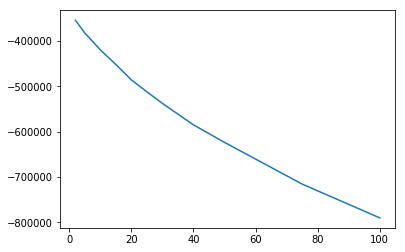

In [322]:
import matplotlib.pyplot as plt
plt.plot(k, all_perplexities)

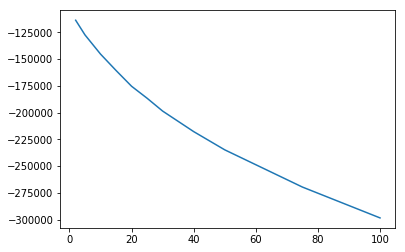

In [323]:
plt.plot(k, green_perplexities)

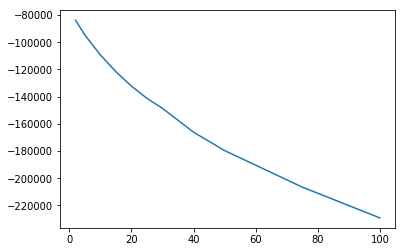

In [324]:
plt.plot(k, synbio_perplexities)

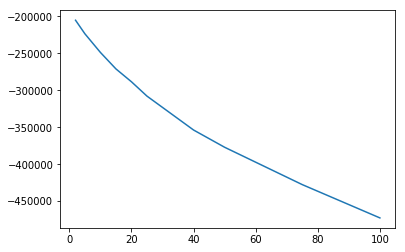

In [325]:
plt.plot(k, nano_perplexities)

#### Predict topics by paragraph

In [326]:
# define data structs and train model
k = 10
topic_by_firm_vector = {} # at the firm level
new_train = synbio_train + synbio_test # train model on all docs

full_dict = corpora.Dictionary(new_train)
DT_matrix = [full_dict.doc2bow(doc) for doc in new_train]
lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=k) 

In [327]:
x=lda.show_topics(num_topics=20, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))

0::[u'product', u'compani', u'develop', u'protect', u'busi', u'system', u'2018', u'make', u'global', u'work']
1::[u'technolog', u'inform', u'product', u'compani', u'work', u'world', u'new', u'2018', u'cancer', u'pleas']
2::[u'product', u'ani', u'servic', u'websit', u'technolog', u'provid', u'custom', u'use', u'world', u'2018']
3::[u'product', u'care', u'technolog', u'solut', u'medic', u'develop', u'health', u'innov', u'new', u'cancer']
4::[u'develop', u'product', u'technolog', u'art', u'global', u'provid', u'manufactur', u'offer', u'innov', u'servic']
5::[u'valu', u'cancer', u'technolog', u'system', u'art', u'bioga', u'compani', u'new', u'inform', u'process']
6::[u'product', u'new', u'technolog', u'innov', u'solut', u'research', u'help', u'develop', u'provid', u'use']
7::[u'use', u'product', u'number', u'health', u'help', u'cancer', u'solut', u'valu', u'peopl', u'research']
8::[u'use', u'product', u'may', u'new', u'offer', u'technolog', u'appli', u'develop', u'provid', u'help']
9::[u'p

In [256]:
for firm_key in all_docs_dict:
    firm_paras = all_docs_dict[firm_key]
    main_topic = [] # at the firm level, where each para is an entry
    main_topic_probs = [] # same, but for probabilities
    para_order = []
    para_len = [] 
    order_num = 1
    for para in firm_paras:
        para_len.append(len(para))
        topic_by_prob = sorted([(i[1],i[0]) for i in lda.get_document_topics(full_dict.doc2bow(para))], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        main_topic_probs.append(topic_by_prob[0][0])
        para_order.append(order_num)
        order_num = order_num + 1
    firm_df = pd.DataFrame(
        {'firm_key': firm_key, 
         'para_order': para_order,
         'num_words': para_len,
         'main_topic': main_topic,
         'prob': main_topic_probs
        })
    topic_by_firm_vector[firm_key] = firm_df # set at the firm level 

In [257]:
print len(topic_by_firm_vector.keys())
print(topic_by_firm_vector['Big Belly Solar.txt'])

857
               firm_key  main_topic  num_words  para_order      prob
0   Big Belly Solar.txt           5         17           1  0.600792
1   Big Belly Solar.txt           2         33           2  0.628842
2   Big Belly Solar.txt           8         35           3  0.506123
3   Big Belly Solar.txt           7         34           4  0.601798
4   Big Belly Solar.txt           0         46           5  0.403525
5   Big Belly Solar.txt           7         26           6  0.966659
6   Big Belly Solar.txt           7         14           7  0.939986
7   Big Belly Solar.txt           1         13           8  0.547348
8   Big Belly Solar.txt           3         12           9  0.930750
9   Big Belly Solar.txt           4         50          10  0.812815
10  Big Belly Solar.txt           4         49          11  0.916151
11  Big Belly Solar.txt           8         41          12  0.844494
12  Big Belly Solar.txt           0         47          13  0.981245
13  Big Belly Solar.txt       

In [259]:
# write to a single output topic file
headers = list(topic_by_firm_vector[topic_by_firm_vector.keys()[0]])
with open(out_file, 'a') as f:
    f.write(','.join(headers) + '\n')
    for firm_key in topic_by_firm_vector:
        df = topic_by_firm_vector[firm_key]
        df.to_csv(f, header=False, index=False)

### Markov Model

In [15]:
from collections import defaultdict
import random

In [21]:
class markov_representation():
    def __init__(self):
        self.tokens = defaultdict(lambda: 0)
        self.transitions = defaultdict(lambda: defaultdict(lambda:0))
        self.for_matrix = defaultdict(lambda: 0)
    def add(self, list_of_tokens):
        for i in range(len(list_of_tokens) ):
            if i <= (len(list_of_tokens)-2):
                self.tokens[str(list_of_tokens[i])]+=1
                self.transitions[str(list_of_tokens[i])][str(list_of_tokens[i + 1])]+=1
                self.for_matrix[(str(list_of_tokens[i]),str(list_of_tokens[i + 1]))] +=1
            else: #separate block to add the last token to the list of tokens
                self.tokens[str(list_of_tokens[i])]+=1
                self.transitions[str(list_of_tokens[i])][None] +=1
    def test(self):
        #return self.transitions
        return self.for_matrix
    #to do: add transition matrix
    def make_transition_matrix(self):
        #tranform dictionary of tuples in self.for_matrix into matrix
        pass
    def generate_sequence(self):
        topic = 'start'
        document = ['start']
        while topic != 'end' and len(document)<20:
            options = self.transitions[topic]
            total = sum(options.values())
            temp = 0
            threshold = random.randint(0, total-1)
            for key, value in options.iteritems():
                temp += value
                if temp>threshold:
                    topic = key
                    break
            document.append(topic)
        if document[-1] != 'end':
            document.append('end')
        return document
        #I want to recursively call this to generate a sequence of the required length, but pass on this for now
#         if len(document) > min_length:
#             return document
#         else:
#             return self.generate_sequence(self, 5)

### Apply Model

In [23]:
model = markov_representation()
for doc in topic_vector:
    model.add(doc)
model.generate_sequence()

['start', '2', '1', '1', '0', 'end']

In [ ]:
## add code to get transition matrix

In [24]:
model.test()

defaultdict(<function __main__.<lambda>>,
            {('0', '0'): 7,
             ('0', '1'): 4,
             ('0', '2'): 4,
             ('0', '3'): 5,
             ('0', 'end'): 2,
             ('1', '0'): 9,
             ('1', '1'): 25,
             ('1', '2'): 4,
             ('1', '3'): 5,
             ('1', 'end'): 4,
             ('2', '0'): 1,
             ('2', '1'): 8,
             ('2', '2'): 17,
             ('2', '3'): 4,
             ('2', 'end'): 3,
             ('3', '0'): 5,
             ('3', '1'): 5,
             ('3', '2'): 4,
             ('3', '3'): 11,
             ('3', 'end'): 1,
             ('start', '1'): 5,
             ('start', '2'): 4,
             ('start', '3'): 1})